In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
from sklearn.preprocessing import OneHotEncoder
import cv2
from google.colab import files
import seaborn as sns

In [ ]:
# Room class to store room dimensions and furniture
class Room:
    def __init__(self, length, width, name="Room"):
        self.length = length
        self.width = width
        self.name = name
        self.furniture = []
        self.fixed_elements = []  # windows, doors, etc.

    def add_furniture(self, furniture):
        self.furniture.append(furniture)

    def add_fixed_element(self, element):
        self.fixed_elements.append(element)

    def get_grid_representation(self, grid_size=20):
        """Convert room to grid representation"""
        grid = np.zeros((int(self.width * grid_size), int(self.length * grid_size)))

        # Add fixed elements to grid (value = 1)
        for element in self.fixed_elements:
            x1 = int(element['x'] * grid_size)
            y1 = int(element['y'] * grid_size)
            x2 = int((element['x'] + element['width']) * grid_size)
            y2 = int((element['y'] + element['length']) * grid_size)
            grid[y1:y2, x1:x2] = 1

        # Add furniture to grid (value = 2)
        for furn in self.furniture:
            x1 = int(furn.x * grid_size)
            y1 = int(furn.y * grid_size)
            x2 = int((furn.x + furn.width) * grid_size)
            y2 = int((furn.y + furn.length) * grid_size)
            grid[y1:y2, x1:x2] = 2

        return grid

    def visualize(self, grid_size=20):
        """Visualize room layout"""
        grid = self.get_grid_representation(grid_size)
        plt.figure(figsize=(10, 10))
        sns.heatmap(grid, cmap=['white', 'black', 'blue'], vmin=0, vmax=2, cbar=False)
        plt.title(f"{self.name} Layout")
        plt.show()

In [ ]:

# Furniture class
class Furniture:
    def __init__(self, name, width, length, movable=True, x=0, y=0, orientation=0):
        self.name = name
        self.width = width
        self.length = length
        self.movable = movable
        self.x = x  # x-coordinate in the room
        self.y = y  # y-coordinate in the room
        self.orientation = orientation  # 0: normal, 90: rotated

    def set_position(self, x, y, orientation=None):
        self.x = x
        self.y = y
        if orientation is not None:
            self.orientation = orientation

    def rotate(self):
        """Rotate furniture by 90 degrees"""
        self.orientation = (self.orientation + 90) % 360
        # Swap width and length if orientation is 90 or 270
        if self.orientation == 90 or self.orientation == 270:
            self.width, self.length = self.length, self.width

    def to_dict(self):
        return {
            'name': self.name,
            'width': self.width,
            'length': self.length,
            'movable': self.movable,
            'x': self.x,
            'y': self.y,
            'orientation': self.orientation
        }

In [ ]:
def generate_synthetic_dataset(num_samples=100):
    """Generate synthetic room layouts"""

    # Define common furniture types with typical dimensions (in meters)
    furniture_types = [
        {'name': 'Bed', 'width': 1.5, 'length': 2.0, 'movable': True},
        {'name': 'Sofa', 'width': 0.9, 'length': 2.2, 'movable': True},
        {'name': 'Table', 'width': 0.8, 'length': 1.2, 'movable': True},
        {'name': 'Chair', 'width': 0.5, 'length': 0.5, 'movable': True},
        {'name': 'Dresser', 'width': 0.5, 'length': 1.2, 'movable': True},
        {'name': 'TV Stand', 'width': 0.4, 'length': 1.5, 'movable': True},
        {'name': 'Bookshelf', 'width': 0.4, 'length': 0.8, 'movable': True},
    ]

    # Fixed elements
    fixed_element_types = [
        {'name': 'Door', 'width': 0.2, 'length': 0.9},
        {'name': 'Window', 'width': 0.1, 'length': 1.2},
    ]

    dataset = []

    for i in range(num_samples):
        # Generate random room dimensions (reasonable sizes in meters)
        room_length = random.uniform(3.0, 6.0)
        room_width = random.uniform(3.0, 5.0)

        room = Room(length=room_length, width=room_width, name=f"Room_{i}")

        # Add 1-2 fixed elements
        num_fixed = random.randint(1, 2)
        for _ in range(num_fixed):
            fixed_type = random.choice(fixed_element_types)
            # Place fixed elements along walls
            wall_choice = random.randint(0, 3)  # 0: top, 1: right, 2: bottom, 3: left

            if wall_choice == 0:  # top wall
                x = random.uniform(0, room_length - fixed_type['length'])
                y = 0
            elif wall_choice == 1:  # right wall
                x = room_length - fixed_type['width']
                y = random.uniform(0, room_width - fixed_type['length'])
            elif wall_choice == 2:  # bottom wall
                x = random.uniform(0, room_length - fixed_type['length'])
                y = room_width - fixed_type['width']
            else:  # left wall
                x = 0
                y = random.uniform(0, room_width - fixed_type['length'])

            fixed_element = {
                'name': fixed_type['name'],
                'width': fixed_type['width'],
                'length': fixed_type['length'],
                'x': x,
                'y': y
            }
            room.add_fixed_element(fixed_element)

        # Add 3-6 furniture items
        num_furniture = random.randint(3, 6)
        selected_furniture = random.sample(furniture_types, num_furniture)

        layout_valid = True
        for furn_type in selected_furniture:
            # Create furniture with random position
            furn = Furniture(
                name=furn_type['name'],
                width=furn_type['width'],
                length=furn_type['length'],
                movable=furn_type['movable']
            )

            # Random orientation (0 or 90 degrees)
            if random.random() > 0.5:
                furn.rotate()

            # Try to place furniture without overlapping
            # This is a simplistic approach - we'll improve it later
            max_attempts = 20
            placed = False

            for _ in range(max_attempts):
                x = random.uniform(0, room_length - furn.length)
                y = random.uniform(0, room_width - furn.width)
                furn.set_position(x, y)

                overlap = False
                # Check overlap with fixed elements
                for element in room.fixed_elements:
                    if (furn.x < element['x'] + element['width'] and
                        furn.x + furn.length > element['x'] and
                        furn.y < element['y'] + element['length'] and
                        furn.y + furn.width > element['y']):
                        overlap = True
                        break

                # Check overlap with other furniture
                for other_furn in room.furniture:
                    if (furn.x < other_furn.x + other_furn.length and
                        furn.x + furn.length > other_furn.x and
                        furn.y < other_furn.y + other_furn.width and
                        furn.y + furn.width > other_furn.y):
                        overlap = True
                        break

                if not overlap:
                    placed = True
                    break

            if not placed:
                layout_valid = False

            room.add_furniture(furn)

        # Calculate features
        furniture_density = sum(f.width * f.length for f in room.furniture) / (room_length * room_width)
        free_space = 1 - furniture_density

        # Calculate furniture-to-wall distances
        wall_distances = []
        for furn in room.furniture:
            dist_left = furn.x
            dist_right = room_length - (furn.x + furn.length)
            dist_top = furn.y
            dist_bottom = room_width - (furn.y + furn.width)
            min_wall_dist = min(dist_left, dist_right, dist_top, dist_bottom)
            wall_distances.append(min_wall_dist)

        avg_wall_distance = sum(wall_distances) / len(wall_distances) if wall_distances else 0

        # Calculate walkability (simplified)
        grid = room.get_grid_representation(grid_size=10)
        empty_cells = np.sum(grid == 0)
        total_cells = grid.size
        walkability = empty_cells / total_cells

        # Store the room layout and features
        room_data = {
            'room_id': i,
            'length': room_length,
            'width': room_width,
            'fixed_elements': room.fixed_elements,
            'furniture': [f.to_dict() for f in room.furniture],
            'features': {
                'furniture_density': furniture_density,
                'free_space': free_space,
                'avg_wall_distance': avg_wall_distance,
                'walkability': walkability
            },
            'valid': layout_valid
        }

        dataset.append(room_data)

    return dataset


In [ ]:

# Generate and save synthetic dataset
synthetic_dataset = generate_synthetic_dataset(100)


In [ ]:

# Save to JSON file
with open('synthetic_room_layouts.json', 'w') as f:
    json.dump(synthetic_dataset, f)


Example Room 1:


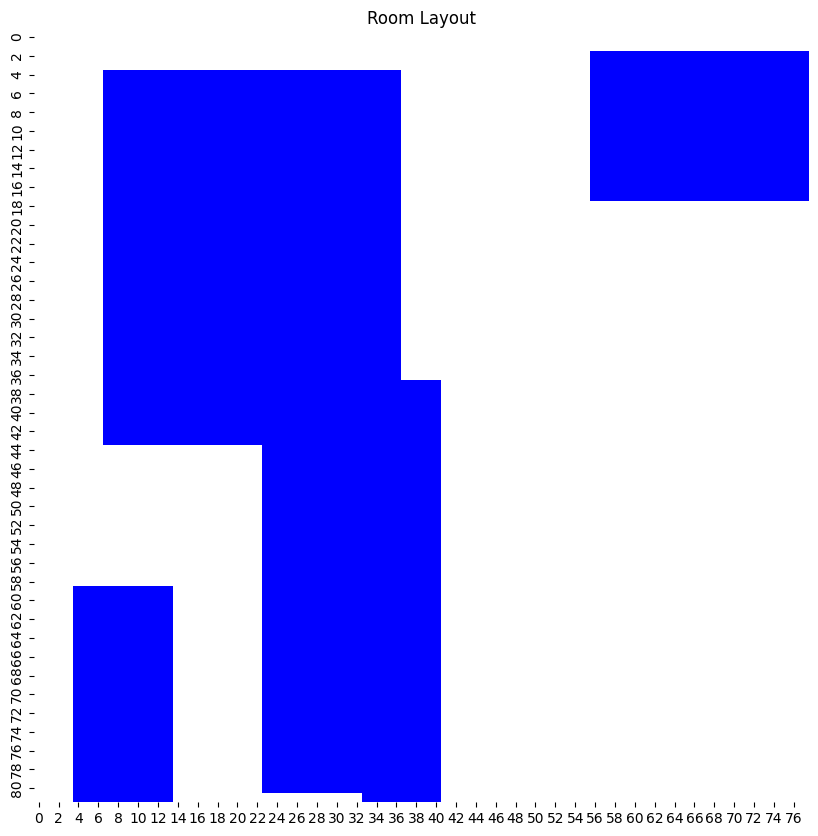

Room dimensions: 3.930908260667519m x 4.106828943008683m
Furniture count: 6
Valid layout: True
Walkability: 0.61
Free space: 0.54

Example Room 2:


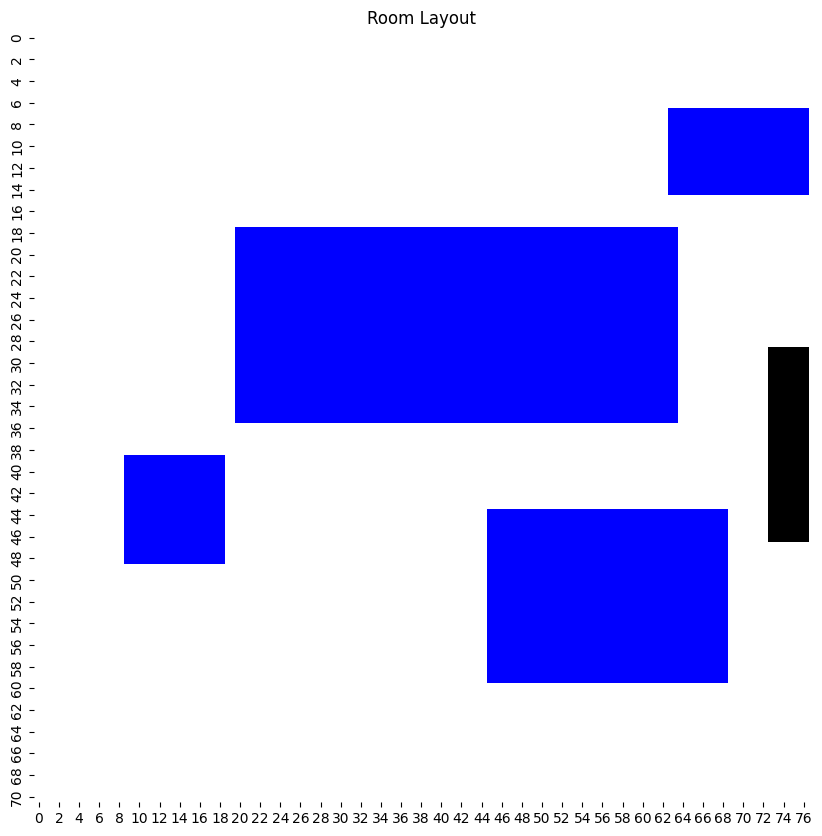

Room dimensions: 3.891755549878555m x 3.5605949833831145m
Furniture count: 4
Valid layout: True
Walkability: 0.73
Free space: 0.73

Example Room 3:


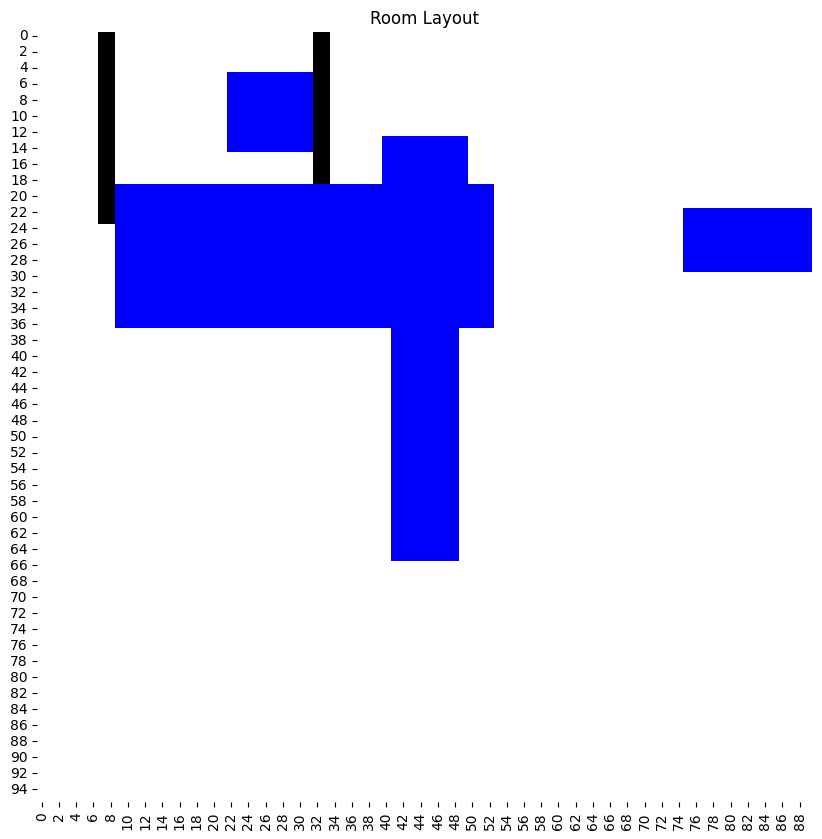

Room dimensions: 4.529210842236566m x 4.808245322953489m
Furniture count: 5
Valid layout: True
Walkability: 0.84
Free space: 0.83


In [ ]:


# Save as CSV for easier ML processing
df_rows = []
for room in synthetic_dataset:
    row = {
        'room_id': room['room_id'],
        'length': room['length'],
        'width': room['width'],
        'num_furniture': len(room['furniture']),
        'num_fixed_elements': len(room['fixed_elements']),
        'furniture_density': room['features']['furniture_density'],
        'free_space': room['features']['free_space'],
        'avg_wall_distance': room['features']['avg_wall_distance'],
        'walkability': room['features']['walkability'],
        'valid': room['valid']
    }
    df_rows.append(row)

df = pd.DataFrame(df_rows)
df.to_csv('synthetic_room_features.csv', index=False)

# Visualize some examples
def visualize_room_from_data(room_data):
    room = Room(length=room_data['length'], width=room_data['width'])

    # Add fixed elements
    for element in room_data['fixed_elements']:
        room.add_fixed_element(element)

    # Add furniture
    for furn_data in room_data['furniture']:
        furn = Furniture(
            name=furn_data['name'],
            width=furn_data['width'],
            length=furn_data['length'],
            movable=furn_data['movable'],
            x=furn_data['x'],
            y=furn_data['y'],
            orientation=furn_data['orientation']
        )
        room.add_furniture(furn)

    # Visualize
    room.visualize()

    # Print room details
    print(f"Room dimensions: {room_data['length']}m x {room_data['width']}m")
    print(f"Furniture count: {len(room_data['furniture'])}")
    print(f"Valid layout: {room_data['valid']}")
    print(f"Walkability: {room_data['features']['walkability']:.2f}")
    print(f"Free space: {room_data['features']['free_space']:.2f}")

# Visualize a few examples
for i in range(3):
    print(f"\nExample Room {i+1}:")
    visualize_room_from_data(synthetic_dataset[i])

In [ ]:
def create_feature_vectors(dataset):
    """Extract numerical features for ML model"""

    features = []
    labels = []

    for room in dataset:
        # Basic room features
        room_vector = [
            room['length'],
            room['width'],
            room['length'] * room['width'],  # area
            len(room['furniture']),
            len(room['fixed_elements']),
        ]

        # Add furniture density features
        room_vector.extend([
            room['features']['furniture_density'],
            room['features']['free_space'],
            room['features']['avg_wall_distance'],
            room['features']['walkability'],
        ])

        # Add furniture type counts
        furniture_types = set(f['name'] for f in room['furniture'])
        room_vector.append(len(furniture_types))

        # Calculate furniture-to-furniture distances (average)
        furniture_coords = [(f['x'] + f['length']/2, f['y'] + f['width']/2) for f in room['furniture']]
        avg_distance = 0
        if len(furniture_coords) > 1:
            distances = []
            for i in range(len(furniture_coords)):
                for j in range(i+1, len(furniture_coords)):
                    x1, y1 = furniture_coords[i]
                    x2, y2 = furniture_coords[j]
                    dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                    distances.append(dist)
            avg_distance = sum(distances) / len(distances)
        room_vector.append(avg_distance)

        features.append(room_vector)
        labels.append(1 if room['valid'] else 0)

    return np.array(features), np.array(labels)

# Create feature vectors
X, y = create_feature_vectors(synthetic_dataset)

# Print feature shape and first example
print(f"Feature vector shape: {X.shape}")
print(f"First feature vector: {X[0]}")
print(f"Label: {y[0]}")

Feature vector shape: (100, 11)
First feature vector: [ 3.93090826  4.10682894 16.14356782  6.          1.          0.46210355
  0.53789645  0.20576585  0.61100688  6.          2.25883376]
Label: 1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Data augmentation function
def augment_data(X, y, num_augmented=500):
    """Create slightly modified versions of valid layouts"""
    X_augmented = []
    y_augmented = []

    valid_indices = np.where(y == 1)[0]

    for _ in range(num_augmented):
        # Pick a random valid layout
        idx = np.random.choice(valid_indices)
        x_orig = X[idx].copy()

        # Apply small random variations to features
        noise = np.random.normal(0, 0.05, size=len(x_orig))
        x_new = x_orig + noise

        X_augmented.append(x_new)
        y_augmented.append(1)  # All augmented layouts are valid

    return np.vstack([X, np.array(X_augmented)]), np.hstack([y, np.array(y_augmented)])

# Apply data augmentation
X_train_aug, y_train_aug = augment_data(X_train, y_train)

print(f"Original training set: {X_train.shape}")
print(f"Augmented training set: {X_train_aug.shape}")

# Save preprocessed data
np.save('X_train.npy', X_train_aug)
np.save('y_train.npy', y_train_aug)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

Original training set: (80, 11)
Augmented training set: (580, 11)


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9500
Precision: 1.0000
Recall: 0.9231
F1 Score: 0.9600

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.92      0.96        13

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



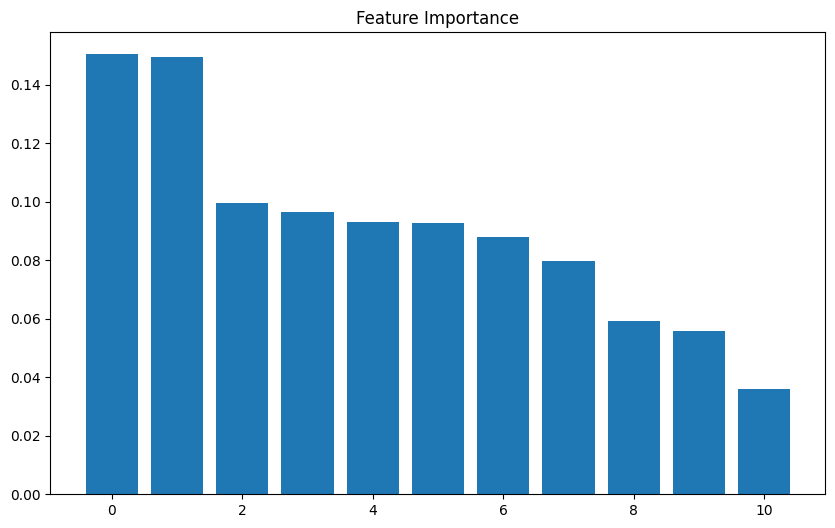

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

# Train a Random Forest model for classifying valid layouts
def train_random_forest(X_train, y_train, X_test, y_test):
    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Create classifier
    rf = RandomForestClassifier(random_state=42)

    # Grid search for best parameters
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    # Get best model
    best_rf = grid_search.best_estimator_

    # Make predictions
    y_pred = best_rf.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importance = best_rf.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(X_train.shape[1]), feature_importance[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

    return best_rf

# Train the model
rf_model = train_random_forest(X_train_aug, y_train_aug, X_test_scaled, y_test)

# Save the model
import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

Generation 0, Best Fitness: 127.26
Generation 10, Best Fitness: 138.08
Generation 20, Best Fitness: 138.08
Generation 30, Best Fitness: 143.75
Generation 40, Best Fitness: 143.75
Generation 50, Best Fitness: 143.75
Generation 60, Best Fitness: 143.75
Generation 70, Best Fitness: 143.75
Generation 80, Best Fitness: 144.07
Generation 90, Best Fitness: 144.07


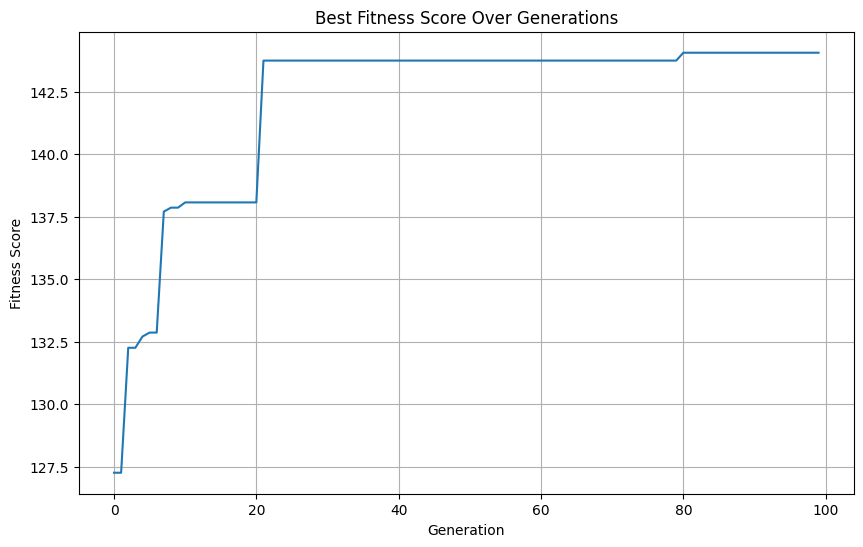

Optimization complete. Best fitness: 144.07
Optimized Room Layout:


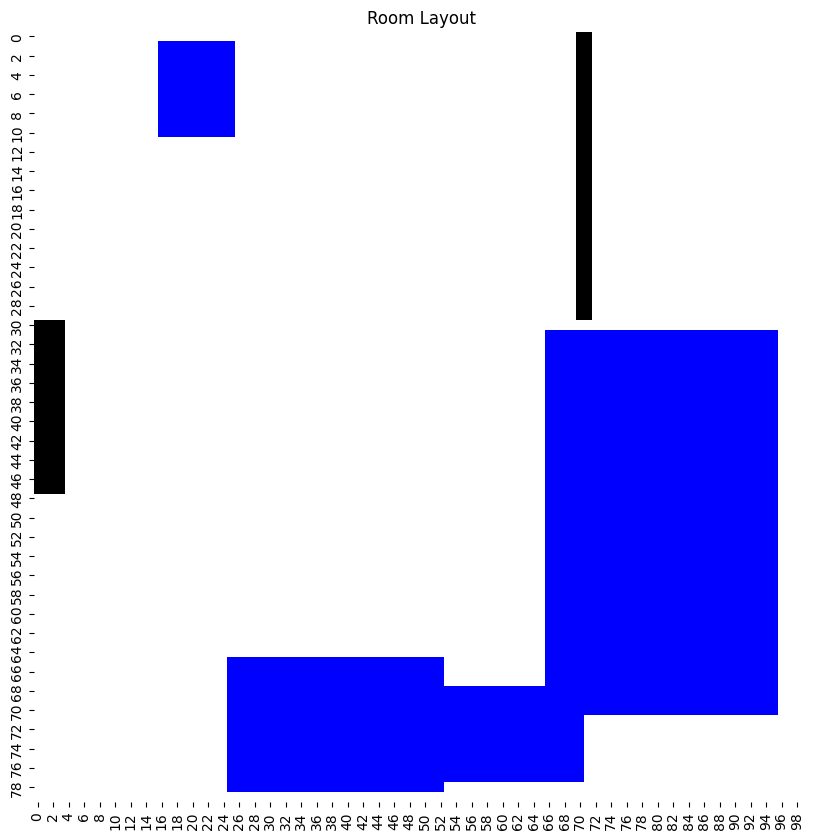


Furniture Positions:
Bed: Position(3.33, 1.59), Size(2.00 x 1.50), Orientation: 0°
Dresser: Position(2.38, 3.42), Size(0.50 x 1.20), Orientation: 180°
Desk: Position(1.28, 3.28), Size(0.70 x 1.40), Orientation: 90°
Chair: Position(0.83, 0.06), Size(0.50 x 0.50), Orientation: 90°


In [ ]:
import numpy as np
import random
import copy

class GeneticLayoutOptimizer:
    def __init__(self, room_length, room_width, furniture_list, fixed_elements=None):
        self.room_length = room_length
        self.room_width = room_width
        self.furniture_list = furniture_list
        self.fixed_elements = fixed_elements if fixed_elements else []

        # GA parameters
        self.population_size = 50
        self.generations = 100
        self.mutation_rate = 0.2
        self.elitism_count = 5

    def initialize_population(self):
        """Create initial random population of furniture layouts"""
        population = []

        for _ in range(self.population_size):
            # Create a new individual (furniture arrangement)
            individual = []

            for furniture in self.furniture_list:
                # Clone furniture item
                furn_copy = copy.deepcopy(furniture)

                # Random orientation (0 or 90 degrees)
                if random.random() > 0.5:
                    furn_copy.rotate()

                # Random position within room bounds
                x = random.uniform(0, self.room_length - furn_copy.length)
                y = random.uniform(0, self.room_width - furn_copy.width)
                furn_copy.set_position(x, y)

                individual.append(furn_copy)

            population.append(individual)

        return population

    def calculate_fitness(self, individual):
        """Calculate fitness score for an individual layout"""
        # Higher score is better
        score = 100

        # Check for overlaps with fixed elements
        for furniture in individual:
            for element in self.fixed_elements:
                if (furniture.x < element['x'] + element['width'] and
                    furniture.x + furniture.length > element['x'] and
                    furniture.y < element['y'] + element['length'] and
                    furniture.y + furniture.width > element['y']):
                    score -= 20  # Heavy penalty for overlapping fixed elements

        # Check for furniture-furniture overlaps
        for i in range(len(individual)):
            for j in range(i+1, len(individual)):
                furn1 = individual[i]
                furn2 = individual[j]

                if (furn1.x < furn2.x + furn2.length and
                    furn1.x + furn1.length > furn2.x and
                    furn1.y < furn2.y + furn2.width and
                    furn1.y + furn1.width > furn2.y):
                    score -= 15  # Penalty for furniture overlap

        # Reward furniture against walls
        for furniture in individual:
            # Check if any edge is close to a wall
            dist_left = furniture.x
            dist_right = self.room_length - (furniture.x + furniture.length)
            dist_top = furniture.y
            dist_bottom = self.room_width - (furniture.y + furniture.width)

            min_wall_dist = min(dist_left, dist_right, dist_top, dist_bottom)

            if min_wall_dist < 0.1:  # Close to wall (10cm)
                score += 5

        # Reward clear walkways (simplified)
        # We'll use a grid-based approach
        grid_size = 20
        grid = np.zeros((int(self.room_width * grid_size), int(self.room_length * grid_size)))

        # Add fixed elements to grid
        for element in self.fixed_elements:
            x1 = int(element['x'] * grid_size)
            y1 = int(element['y'] * grid_size)
            x2 = int((element['x'] + element['width']) * grid_size)
            y2 = int((element['y'] + element['length']) * grid_size)
            grid[y1:y2, x1:x2] = 1

        # Add furniture to grid
        for furn in individual:
            x1 = int(furn.x * grid_size)
            y1 = int(furn.y * grid_size)
            x2 = int((furn.x + furn.length) * grid_size)
            y2 = int((furn.y + furn.width) * grid_size)
            grid[y1:y2, x1:x2] = 1

        # Calculate walkability
        empty_cells = np.sum(grid == 0)
        total_cells = grid.size
        walkability = empty_cells / total_cells

        score += walkability * 30  # Reward for good walkability

        # If score is negative, set to 0
        score = max(0, score)

        return score

    def select_parents(self, population, fitness_scores):
        """Select parents for crossover using tournament selection"""
        tournament_size = 3
        parents = []

        for _ in range(2):
            # Select random subset of individuals
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament_fitness = [fitness_scores[i] for i in tournament_indices]

            # Select winner (highest fitness)
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            parents.append(population[winner_idx])

        return parents

    def crossover(self, parent1, parent2):
        """Create a child layout by combining elements from both parents"""
        child = []

        for i in range(len(parent1)):
            # 50% chance to inherit from each parent
            if random.random() < 0.5:
                child.append(copy.deepcopy(parent1[i]))
            else:
                child.append(copy.deepcopy(parent2[i]))

        return child

    def mutate(self, individual):
        """Apply random mutations to an individual"""
        for furniture in individual:
            # Mutate position
            if random.random() < self.mutation_rate:
                x = random.uniform(0, self.room_length - furniture.length)
                y = random.uniform(0, self.room_width - furniture.width)
                furniture.set_position(x, y)

            # Mutate orientation
            if random.random() < self.mutation_rate:
                furniture.rotate()

        return individual

    def optimize(self):
        """Run the genetic algorithm optimization"""
        # Initialize population
        population = self.initialize_population()

        best_fitness_history = []
        best_individual = None
        best_fitness = 0

        for generation in range(self.generations):
            # Calculate fitness for each individual
            fitness_scores = [self.calculate_fitness(ind) for ind in population]

            # Track best individual
            max_fitness_idx = np.argmax(fitness_scores)
            if fitness_scores[max_fitness_idx] > best_fitness:
                best_fitness = fitness_scores[max_fitness_idx]
                best_individual = copy.deepcopy(population[max_fitness_idx])

            best_fitness_history.append(best_fitness)

            if generation % 10 == 0:
                print(f"Generation {generation}, Best Fitness: {best_fitness:.2f}")

            # Create new population
            new_population = []

            # Elitism - keep best individuals
            sorted_indices = np.argsort(fitness_scores)[::-1]
            for i in range(self.elitism_count):
                new_population.append(copy.deepcopy(population[sorted_indices[i]]))

            # Create the rest through crossover and mutation
            while len(new_population) < self.population_size:
                # Select parents
                parents = self.select_parents(population, fitness_scores)

                # Crossover
                child = self.crossover(parents[0], parents[1])

                # Mutation
                child = self.mutate(child)

                new_population.append(child)

            population = new_population

        # Plot fitness history
        plt.figure(figsize=(10, 6))
        plt.plot(best_fitness_history)
        plt.title('Best Fitness Score Over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Fitness Score')
        plt.grid(True)
        plt.show()

        print(f"Optimization complete. Best fitness: {best_fitness:.2f}")

        return best_individual, best_fitness

# Example usage of the genetic algorithm
def create_room_with_furniture(room_length, room_width, furniture_list, fixed_elements=None):
    room = Room(length=room_length, width=room_width)

    # Add fixed elements
    if fixed_elements:
        for element in fixed_elements:
            room.add_fixed_element(element)

    # Add furniture
    for furniture in furniture_list:
        room.add_furniture(furniture)

    return room

# Create a test scenario
def test_optimization():
    # Room dimensions
    room_length = 5.0  # meters
    room_width = 4.0   # meters

    # Fixed elements (doors, windows)
    fixed_elements = [
        {'name': 'Door', 'width': 0.2, 'length': 0.9, 'x': 0, 'y': 1.5},
        {'name': 'Window', 'width': 0.1, 'length': 1.5, 'x': 3.5, 'y': 0}
    ]

    # Furniture to arrange
    furniture_list = [
        Furniture(name='Bed', width=1.5, length=2.0),
        Furniture(name='Dresser', width=0.5, length=1.2),
        Furniture(name='Desk', width=0.7, length=1.4),
        Furniture(name='Chair', width=0.5, length=0.5)
    ]

    # Create optimizer
    optimizer = GeneticLayoutOptimizer(
        room_length=room_length,
        room_width=room_width,
        furniture_list=furniture_list,
        fixed_elements=fixed_elements
    )

    # Run optimization
    best_layout, fitness = optimizer.optimize()

    # Create and visualize the optimized room
    optimized_room = create_room_with_furniture(
        room_length=room_length,
        room_width=room_width,
        furniture_list=best_layout,
        fixed_elements=fixed_elements
    )

    print("Optimized Room Layout:")
    optimized_room.visualize()

    # Print furniture positions
    print("\nFurniture Positions:")
    for furniture in best_layout:
        print(f"{furniture.name}: Position({furniture.x:.2f}, {furniture.y:.2f}), " +
              f"Size({furniture.length:.2f} x {furniture.width:.2f}), " +
              f"Orientation: {furniture.orientation}°")

    return optimized_room, best_layout, fitness

# Run the optimization test
optimized_room, best_layout, fitness = test_optimization()